# Choosing the Best Restaurant Location in NYC
**Applied Data Science Capstone Project**  
*Janrey Nevado*  
May 26, 2020

## Introduction

### Background

New York City is the most populous city in the United States and the New York metropolitan area is one of the most populous in the world. More than 800 languages are spoken in New York City, making it the most linguistically diverse city in the world. 4 in 10 households speak a language other than English. These make New York City an attractive location for restaurants because higher population and population density means higher foot traffic for business establishments and diversity means more people will be more open-minded when they are introduced to new things. However, foot traffic and diversity should not be just the factors to consider when choosing a location.
<br/>
<br/>
Finding a good restaurant location is harder than some people think. While a busy street may look like a perfect location for a restaurant, it may not be always the case. Food and service are important to the success of a restaurant, but the location is just as crucial. Some other factors to consider include the following: (1) parking, (2) accessibility, (3) number of competitors, and (4) crime rates among others. While these factors do not ultimately determine a restaurant’s success, knowing these is a better starting point than not knowing them at all.


### Problem Statement

A new market entrant is looking for opportunities to expand their restaurant business in New York City. They would like to try establishing a new brand of restaurant that is not yet in their portfolio. The company is looking to have answers to the following questions.

1. Which neighborhood(s) is/are the best location(s) to build a new restaurant considering the following factors:
    - Historical crime rate
    - Number of competitors
2. What cuisine dominates in each of the neighborhoods?
3. Knowing these things, what cuisine could be introduced to the location?


### Target Audience

To answer these questions, the company reached out to our team. The company’s objective is to locate the best neighborhood(s) to build a new restaurant in. The company also expects to understand the rationale behind the recommendations.

#### Importing necessary modules

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import folium
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

#### Loading the data

Get New York City's list of boroughs and neighborhoods with their corresponding coordinates

In [2]:
new_york_data = pd.read_csv("https://raw.githubusercontent.com/zerokelvin09/Coursera_Capstone/master/new_york_data.csv")

In [3]:
new_york_data.head()

Borough  Neighborhood   Latitude  Longitude
0   Bronx      Allerton  40.865788 -73.859319
1   Bronx    Baychester  40.866858 -73.835798
2   Bronx  Bedford Park  40.870185 -73.885512
3   Bronx       Belmont  40.857277 -73.888452
4   Bronx     Bronxdale  40.852723 -73.861726

In [4]:
new_york_data.shape

(306, 4)

Get New York City's crime data (2015-2019)

In [5]:
new_york_crime_data = pd.read_csv("https://raw.githubusercontent.com/zerokelvin09/Coursera_Capstone/master/nypd_complaint_data_2015_to_2019.csv")

In [6]:
new_york_crime_data.head()

CMPLNT_NUM  ADDR_PCT_CD        BORO_NM CMPLNT_FR_DT CMPLNT_FR_TM  \
0   172973895           40          BRONX   01/01/2015     00:01:00   
1   954680514          122  STATEN ISLAND   01/01/2015     00:00:00   
2   857809698           44          BRONX   01/01/2015     01:11:00   
3   457817423           14      MANHATTAN   01/04/2015     17:00:00   
4   111333425          113         QUEENS   01/24/2015     15:00:00   

  CMPLNT_TO_DT CMPLNT_TO_TM CRM_ATPT_CPTD_CD HADEVELOPT  HOUSING_PSA  ...  \
0   12/31/2016     00:00:00        COMPLETED        NaN          NaN  ...   
1   05/05/2017     00:00:00        COMPLETED        NaN          NaN  ...   
2   02/22/2020     17:15:00        COMPLETED        NaN          NaN  ...   
3   02/18/2020     16:27:00        COMPLETED        NaN          NaN  ...   
4   01/24/2020     13:00:00        COMPLETED        NaN          NaN  ...   

   SUSP_SEX TRANSIT_DISTRICT  VIC_AGE_GROUP        VIC_RACE VIC_SEX  \
0         M              NaN            <18  WHITE HISPANIC       F   
1         M              NaN            <18           WHITE       F   
2       NaN              NaN          45-64  WHITE HISPANIC       F   
3       NaN              NaN          45-64         UNKNOWN       M   
4       NaN              NaN          25-44           BLACK       F   

  X_COORD_CD Y_COORD_CD   Latitude  Longitude  \
0    1004926     234532  40.810396 -73.925311   
1     954943     148360  40.573850 -74.105496   
2    1006536     241720  40.830121 -73.919471   
3     985821     211959  40.748463 -73.994332   
4    1048773     194414  40.700071 -73.767302   

                                    Lat_Lon  
0   (40.81039601900005, -73.92531074499993)  
1  (40.573849649000074, -74.10549615599997)  
2  (40.830121132000045, -73.91947085699996)  
3   (40.74846314200005, -73.99433158899996)  
4   (40.70007128000003, -73.76730177499996)  

[5 rows x 35 columns]

In [7]:
new_york_crime_data.shape

(5540, 35)

#### Processing the data

For this study, we will only need the following columns:  
- `CMPLNT_NUM`: Randomly generated persistent ID for each complaint
- `BORO_NM`: The name of the borough in which the incident occurred
- `CMPLNT_FR_DT`: Exact date of occurrence for the reported event
- `LAW_CAT_CD`: Level of offense: felony, misdemeanor, violation
- `Latitude`: Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326) 
- `Longitude`: Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326) 

In [8]:
new_york_crime_data = new_york_crime_data[['CMPLNT_NUM', 'BORO_NM', 'CMPLNT_FR_DT', 'LAW_CAT_CD', 'Latitude', 'Longitude']]
new_york_crime_data.rename(columns = {'CMPLNT_NUM': 'Complaint ID', 'BORO_NM': 'Borough', 'CMPLNT_FR_DT': 'Complaint Date', 'LAW_CAT_CD': 'Level of Offense'}, inplace = True)

In [9]:
new_york_crime_data.head()

Complaint ID        Borough Complaint Date Level of Offense   Latitude  \
0     172973895          BRONX     01/01/2015           FELONY  40.810396   
1     954680514  STATEN ISLAND     01/01/2015           FELONY  40.573850   
2     857809698          BRONX     01/01/2015           FELONY  40.830121   
3     457817423      MANHATTAN     01/04/2015           FELONY  40.748463   
4     111333425         QUEENS     01/24/2015           FELONY  40.700071   

   Longitude  
0 -73.925311  
1 -74.105496  
2 -73.919471  
3 -73.994332  
4 -73.767302

Let's map the locations where crimes occurred

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent = "ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_nyc = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(new_york_crime_data['Latitude'], new_york_crime_data['Longitude'], new_york_crime_data['Borough']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_nyc)
    
map_nyc

To get the specific neighborhood, we need to reverse geocode the coordinates. We will be using Mapbox API for this.

In [11]:
new_york_crime_data.head()

Complaint ID        Borough Complaint Date Level of Offense   Latitude  \
0     172973895          BRONX     01/01/2015           FELONY  40.810396   
1     954680514  STATEN ISLAND     01/01/2015           FELONY  40.573850   
2     857809698          BRONX     01/01/2015           FELONY  40.830121   
3     457817423      MANHATTAN     01/04/2015           FELONY  40.748463   
4     111333425         QUEENS     01/24/2015           FELONY  40.700071   

   Longitude  
0 -73.925311  
1 -74.105496  
2 -73.919471  
3 -73.994332  
4 -73.767302

In [12]:
new_york_crime_data_with_neighborhood = new_york_crime_data.copy()

We'll run this code to get the respective neighborhoods of the coordinates provided.

```python
from mapbox import Geocoder

geocoder = Geocoder(access_token = 'YOUR_MAPBOX_ACCESS_TOKEN')

tqdm_notebook.pandas()

def geocode_coordinates(longitude, latitude):
    response = geocoder.reverse(lon = longitude, lat = latitude)
    neighborhood = str(response.json()['features'][0]['context'][0]['text'])
    return neighborhood
    
new_york_crime_data_with_neighborhood['Neighborhood'] = new_york_crime_data_with_neighborhood.progress_apply(lambda row: geocode_coordinates(row['Longitude'], row['Latitude']), axis = 1)
```

We'll save the data frame to minimize the use of API calls
```python
new_york_crime_data_with_neighborhood.to_csv('nypd_complaint_data_2015_to_2019_with_neighborhood.csv', index = False)
```

The data frame is cleaned by removing incomplete records.

In [13]:
new_york_crime_data_with_neighborhood = pd.read_csv('https://raw.githubusercontent.com/zerokelvin09/Coursera_Capstone/master/nypd_complaint_data_2015_to_2019_with_neighborhood.csv')

Let's prepare the data frame for aggregation.

In [14]:
new_york_crime_data_with_neighborhood['Neighborhood'] = new_york_crime_data_with_neighborhood['Neighborhood'].str.upper()
new_york_crime_data_with_neighborhood['Level of Offense'] = new_york_crime_data_with_neighborhood['Level of Offense'].str.title()
new_york_crime_data_with_neighborhood['Complaint Date'] = pd.to_datetime(new_york_crime_data_with_neighborhood['Complaint Date'])
new_york_crime_data_with_neighborhood['Complaint Date'] = new_york_crime_data_with_neighborhood['Complaint Date'].dt.year
new_york_crime_data_with_neighborhood = new_york_crime_data_with_neighborhood.rename(columns = {'Complaint Date': 'Year'})
new_york_crime_data_with_neighborhood = new_york_crime_data_with_neighborhood.drop(['Latitude', 'Longitude'], axis = 1)

In [15]:
new_york_crime_data_with_neighborhood.head()

Complaint ID        Borough  Year Level of Offense Neighborhood
0     172973895          BRONX  2015           Felony   MOTT HAVEN
1     954680514  STATEN ISLAND  2015           Felony   GRANT CITY
2     857809698          BRONX  2015           Felony    CONCOURSE
3     457817423      MANHATTAN  2015           Felony     FLATIRON
4     111333425         QUEENS  2015           Felony       HOLLIS

We'll generate new columns from the data:
- `Average Number of Felony Cases`: Five-year average of felony cases
- `Average Number of Misdemeanor Cases`: Five-year average of misdemeanor cases
- `Average Number of Violation Cases`: Five-year average of violation cases

But first, we need to get the number of cases by level of offense and by year, then reshape the data.

In [16]:
new_york_crime_data_with_neighborhood_agg = new_york_crime_data_with_neighborhood.copy()

In [17]:
new_york_crime_data_with_neighborhood_agg = new_york_crime_data_with_neighborhood_agg.groupby(['Borough', 'Neighborhood', 'Level of Offense', 'Year'], as_index = False).count()
new_york_crime_data_with_neighborhood_agg = new_york_crime_data_with_neighborhood_agg.rename(columns = {'Complaint ID': 'Number of Cases'}) 
new_york_crime_data_with_neighborhood_agg = new_york_crime_data_with_neighborhood_agg.sort_values(['Borough', 'Neighborhood', 'Level of Offense', 'Year'])
new_york_crime_data_with_neighborhood_agg['Level of Offense and Year'] = new_york_crime_data_with_neighborhood_agg.agg('{0[Level of Offense]} {0[Year]}'.format, axis = 1)
new_york_crime_data_with_neighborhood_agg = new_york_crime_data_with_neighborhood_agg.drop(['Level of Offense', 'Year'], axis = 1)

In [18]:
new_york_crime_data_with_neighborhood_agg.head()

Borough  Neighborhood  Number of Cases Level of Offense and Year
0   BRONX    BAYCHESTER                1               Felony 2018
1   BRONX    BAYCHESTER                4               Felony 2019
2   BRONX    BAYCHESTER                6          Misdemeanor 2019
3   BRONX  BEDFORD PARK                1               Felony 2018
4   BRONX  BEDFORD PARK               11               Felony 2019

In [19]:
new_york_crime_data_reshaped = new_york_crime_data_with_neighborhood_agg.pivot_table(index = ['Borough', 'Neighborhood'], columns = 'Level of Offense and Year', values = 'Number of Cases')\
.rename_axis(None, axis=1)\
.reset_index()

new_york_crime_data_reshaped = new_york_crime_data_reshaped.fillna(0)
new_york_crime_data_reshaped = new_york_crime_data_reshaped.drop('Borough', axis = 1)

In [20]:
new_york_crime_data_reshaped.head(100)

Neighborhood  Felony 2015  Felony 2016  Felony 2017  \
0                  BAYCHESTER          0.0          0.0          0.0   
1                BEDFORD PARK          0.0          0.0          0.0   
2                     BELMONT          0.0          0.0          0.0   
3                 CASTLE HILL          0.0          0.0          0.0   
4                 CITY ISLAND          0.0          0.0          1.0   
5                CLASON POINT          0.0          0.0          0.0   
6                  CO-OP CITY          0.0          0.0          0.0   
7                   CONCOURSE          1.0          1.0          0.0   
8                EAST TREMONT          0.0          0.0          0.0   
9                 EASTCHESTER          0.0          0.0          0.0   
10                  FIELDSTON          0.0          0.0          0.0   
11                    FORDHAM          0.0          0.0          1.0   
12                HIGH BRIDGE          0.0          0.0          0.0   
13                HUNTS POINT          0.0          1.0          0.0   
14                KINGSBRIDGE          0.0          0.0          0.0   
15                   LONGWOOD          1.0          0.0          0.0   
16                    MELROSE          0.0          0.0          1.0   
17             MORRIS HEIGHTS          0.0          0.0          0.0   
18                MORRIS PARK          0.0          1.0          0.0   
19                 MOTT HAVEN          1.0          1.0          0.0   
20            NORTH RIVERDALE          0.0          0.0          0.0   
21                    NORWOOD          0.0          2.0          1.0   
22                PARKCHESTER          0.0          0.0          0.0   
23                 PELHAM BAY          0.0          1.0          0.0   
24             PELHAM GARDENS          0.0          0.0          0.0   
25                PORT MORRIS          0.0          0.0          0.0   
26                  RIVERDALE          0.0          0.0          0.0   
27                  SOUNDVIEW          1.0          1.0          2.0   
28             SPUYTEN DUYVIL          0.0          0.0          0.0   
29                THROGS NECK          0.0          0.0          0.0   
..                        ...          ...          ...          ...   
70                 KENSINGTON          1.0          0.0          0.0   
71            MANHATTAN BEACH          0.0          0.0          0.0   
72                MARINE PARK          0.0          0.0          0.0   
73                    MIDWOOD          0.0          0.0          1.0   
74                 MILL BASIN          0.0          0.0          0.0   
75                 OCEAN HILL          0.0          0.0          0.0   
76              OCEAN PARKWAY          0.0          0.0          0.0   
77                 PARK SLOPE          0.0          0.0          0.0   
78           PROSPECT HEIGHTS          0.0          0.0          0.0   
79  PROSPECT LEFFERTS GARDENS          0.0          0.0          0.0   
80                   RED HOOK          0.0          0.0          1.0   
81             SHEEPSHEAD BAY          0.0          0.0          2.0   
82                SUNSET PARK          0.0          0.0          0.0   
83               WILLIAMSBURG          0.0          0.0          2.0   
84            WINDSOR TERRACE          0.0          0.0          0.0   
85                    WINGATE          0.0          1.0          0.0   
86          BATTERY PARK CITY          0.0          0.0          0.0   
87              CARNEGIE HILL          0.0          0.0          0.0   
88             CENTRAL HARLEM          0.0          0.0          1.0   
89                    CHELSEA          0.0          1.0          0.0   
90                  CHINATOWN          0.0          0.0          1.0   
91                    CLINTON          0.0          0.0          0.0   
92                EAST HARLEM          2.0          1.0          1.0   
93               EAST VILLAGE          1.0          0.0  

Now that we're done reshaping the data, let's add the new columns.

In [21]:
new_york_crime_data_reshaped['Average Number of Felony Cases'] = new_york_crime_data_reshaped[['Felony 2015', 'Felony 2016', 'Felony 2017', 'Felony 2018', 'Felony 2019']].mean(axis = 1)
new_york_crime_data_reshaped['Average Number of Misdemeanor Cases'] = new_york_crime_data_reshaped[['Misdemeanor 2015', 'Misdemeanor 2016', 'Misdemeanor 2017', 'Misdemeanor 2018', 'Misdemeanor 2019']].mean(axis = 1)
new_york_crime_data_reshaped['Average Number of Violation Cases'] = new_york_crime_data_reshaped[['Violation 2015', 'Violation 2016', 'Violation 2017', 'Violation 2018', 'Violation 2019']].mean(axis = 1)

In [22]:
new_york_crime_data_reshaped.head()

Neighborhood  Felony 2015  Felony 2016  Felony 2017  Felony 2018  \
0    BAYCHESTER          0.0          0.0          0.0          1.0   
1  BEDFORD PARK          0.0          0.0          0.0          1.0   
2       BELMONT          0.0          0.0          0.0          0.0   
3   CASTLE HILL          0.0          0.0          0.0          0.0   
4   CITY ISLAND          0.0          0.0          1.0          1.0   

   Felony 2019  Misdemeanor 2015  Misdemeanor 2016  Misdemeanor 2017  \
0          4.0               0.0               0.0               0.0   
1         11.0               0.0               0.0               0.0   
2          3.0               0.0               0.0               0.0   
3          6.0               0.0               0.0               0.0   
4          0.0               0.0               0.0               0.0   

   Misdemeanor 2018  Misdemeanor 2019  Violation 2015  Violation 2016  \
0               0.0               6.0             0.0             0.0   
1               0.0              11.0             0.0             0.0   
2               0.0               5.0             0.0             0.0   
3               0.0              16.0             0.0             0.0   
4               0.0               1.0             0.0             0.0   

   Violation 2017  Violation 2018  Violation 2019  \
0             0.0             0.0             0.0   
1             0.0             0.0             2.0   
2             0.0             0.0             0.0   
3             0.0             0.0             0.0   
4             0.0             0.0             0.0   

   Average Number of Felony Cases  Average Number of Misdemeanor Cases  \
0                             1.0                                  1.2   
1                             2.4                                  2.2   
2                             0.6                                  1.0   
3                             1.2                                  3.2   
4                             0.4                                  0.2   

   Average Number of Violation Cases  
0                                0.0  
1                                0.4  
2                                0.0  
3                                0.0  
4                                0.0

Let's check which neighborhoods have the highest average number of crimes by level of offense.

1. Felony

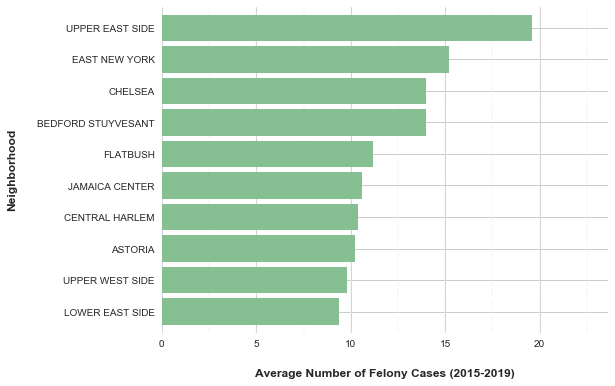

In [23]:
top_felony_count = new_york_crime_data_reshaped.groupby('Neighborhood')['Average Number of Felony Cases'].sum().sort_values().tail(10)

ax = top_felony_count.plot(kind='barh', figsize=(8, 6), color='#86bf91', zorder=2, width=0.85)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Average Number of Felony Cases (2015-2019)", labelpad=20, weight='bold', size=12)

ax.set_ylabel("Neighborhood", labelpad=20, weight='bold', size=12)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

2. Misdemeanor

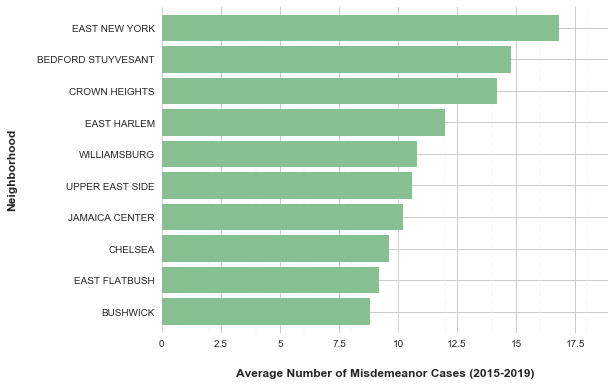

In [24]:
top_misdemeanor_count = new_york_crime_data_reshaped.groupby('Neighborhood')['Average Number of Misdemeanor Cases'].sum().sort_values().tail(10)

ax = top_misdemeanor_count.plot(kind='barh', figsize=(8, 6), color='#86bf91', zorder=2, width=0.85)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Average Number of Misdemeanor Cases (2015-2019)", labelpad=20, weight='bold', size=12)

ax.set_ylabel("Neighborhood", labelpad=20, weight='bold', size=12)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

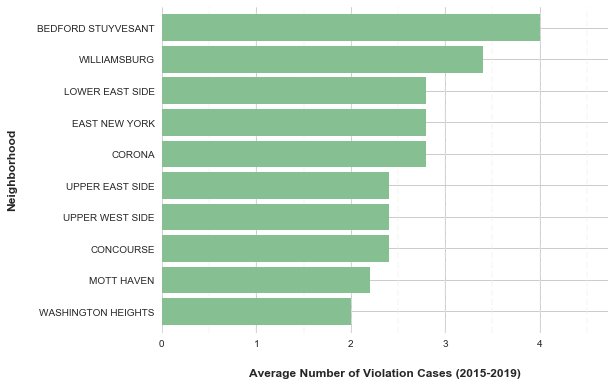

In [25]:
top_violation_count = new_york_crime_data_reshaped.groupby('Neighborhood')['Average Number of Violation Cases'].sum().sort_values().tail(10)

ax = top_violation_count.plot(kind='barh', figsize=(8, 6), color='#86bf91', zorder=2, width=0.85)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Average Number of Violation Cases (2015-2019)", labelpad=20, weight='bold', size=12)

ax.set_ylabel("Neighborhood", labelpad=20, weight='bold', size=12)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

According to the charts, neighborhoods in Manhattan and Brooklyn (**Bedford Stuyvesant**, **East New York**, **Lower East Side**, **Upper East Side**, and **Upper West Side**) are common in all levels of offense.

Let's move on with processing the location data.

In [26]:
CLIENT_ID = 'YOUR_CLIENT_ID'
CLIENT_SECRET = 'YOUR_CLIENT_SECRET'
ACCESS_TOKEN = 'YOUR_ACCESS_TOKEN'
VERSION = '20180605'
LIMIT = 100
RADIUS = 500

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            ACCESS_TOKEN,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We'll run this code to get the venues near the centroids of the neighborhood.

```python
new_york_venues = getNearbyVenues(names = new_york_data['Neighborhood'],
                                   latitudes = new_york_data['Latitude'],
                                   longitudes = new_york_data['Longitude']
                                  )
```

Let's save the resulting data frame to minimize the usage of API calls.

```python
new_york_venues.to_csv('new_york_city_venues.csv', index = False)
```

In [28]:
new_york_venues = pd.read_csv('https://raw.githubusercontent.com/zerokelvin09/Coursera_Capstone/master/new_york_city_venues.csv')

In [29]:
new_york_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Allerton              40.865788              -73.859319   
1     Allerton              40.865788              -73.859319   
2     Allerton              40.865788              -73.859319   
3     Allerton              40.865788              -73.859319   
4     Allerton              40.865788              -73.859319   

                        Venue  Venue Latitude  Venue Longitude  \
0         Domenick's Pizzeria       40.865576       -73.858124   
1  Bronx Martial Arts Academy       40.865721       -73.857529   
2                White Castle       40.866065       -73.862307   
3                     Dunkin'       40.865204       -73.859007   
4           Sal & Doms Bakery       40.865377       -73.855236   

         Venue Category  
0           Pizza Place  
1     Martial Arts Dojo  
2  Fast Food Restaurant  
3            Donut Shop  
4          Dessert Shop

Let's find out how many unique categories can be curated from all the returned venues

In [30]:
print('There are {} uniques categories.'.format(len(new_york_venues['Venue Category'].unique())))

There are 478 uniques categories.


Now, let's perform one hot encoding on the dataset and only get the venues that contain the word *restaurant*.

In [31]:
new_york_onehot = pd.get_dummies(new_york_venues[['Venue Category']], prefix="", prefix_sep="")

new_york_onehot['Neighborhood'] = new_york_venues['Neighborhood']
new_york_onehot['Neighborhood'] = new_york_onehot['Neighborhood'].str.upper()
new_york_onehot = new_york_onehot.loc[:, new_york_onehot.columns.str.contains('Neighborhood|Restaurant')]
new_york_onehot = new_york_onehot[['Neighborhood', 'Afghan Restaurant', 'African Restaurant', 'American Restaurant','Arepa Restaurant', 'Argentinian Restaurant', 'Asian Restaurant','Australian Restaurant', 'Austrian Restaurant', 'Brazilian Restaurant','Burmese Restaurant', 'Cajun / Creole Restaurant','Cambodian Restaurant', 'Cantonese Restaurant', 'Caribbean Restaurant','Caucasian Restaurant', 'Chinese Restaurant', 'Colombian Restaurant','Comfort Food Restaurant', 'Cuban Restaurant', 'Czech Restaurant','Dim Sum Restaurant', 'Dumpling Restaurant','Eastern European Restaurant', 'Egyptian Restaurant','Empanada Restaurant', 'English Restaurant', 'Ethiopian Restaurant','Falafel Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant','French Restaurant', 'German Restaurant', 'Gluten-free Restaurant','Greek Restaurant', 'Halal Restaurant', 'Hawaiian Restaurant','Himalayan Restaurant', 'Hotpot Restaurant', 'Hunan Restaurant','Indian Restaurant', 'Indonesian Restaurant', 'Israeli Restaurant','Italian Restaurant', 'Japanese Curry Restaurant','Japanese Restaurant', 'Jewish Restaurant', 'Kebab Restaurant','Korean Restaurant', 'Kosher Restaurant', 'Latin American Restaurant','Lebanese Restaurant', 'Malay Restaurant', 'Mediterranean Restaurant','Mexican Restaurant', 'Middle Eastern Restaurant','Modern European Restaurant', 'Molecular Gastronomy Restaurant','Moroccan Restaurant', 'New American Restaurant','North Indian Restaurant', 'Paella Restaurant', 'Pakistani Restaurant','Persian Restaurant', 'Peruvian Restaurant', 'Polish Restaurant','Ramen Restaurant', 'Russian Restaurant','Scandinavian Restaurant', 'Seafood Restaurant','Shabu-Shabu Restaurant', 'Shanghai Restaurant', 'Soba Restaurant','South American Restaurant', 'Southern / Soul Food Restaurant','Spanish Restaurant', 'Sri Lankan Restaurant', 'Sushi Restaurant','Swiss Restaurant', 'Szechuan Restaurant', 'Taiwanese Restaurant','Tapas Restaurant', 'Tex-Mex Restaurant', 'Thai Restaurant','Tibetan Restaurant', 'Turkish Restaurant', 'Udon Restaurant','Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant']]

new_york_onehot.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0     ALLERTON                  0                   0                    0   
1     ALLERTON                  0                   0                    0   
2     ALLERTON                  0                   0                    0   
3     ALLERTON                  0                   0                    0   
4     ALLERTON                  0                   0                    0   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0                 0                       0                 0   
1                 0                       0                 0   
2                 0                       0                 0   
3                 0                       0                 0   
4                 0                       0                 0   

   Australian Restaurant  Austrian Restaurant  Brazilian Restaurant  ...  \
0                      0                    0                     0  ...   
1                      0                    0                     0  ...   
2                      0                    0                     0  ...   
3                      0                    0                     0  ...   
4                      0                    0                     0  ...   

   Szechuan Restaurant  Taiwanese Restaurant  Tapas Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Tex-Mex Restaurant  Thai Restaurant  Tibetan Restaurant  \
0                   0                0                   0   
1                   0                0                   0   
2                   0                0                   0   
3                   0                0                   0   
4                   0                0                   0   

   Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0                   0                0                              0   
1                   0                0                              0   
2                   0                0                              0   
3                   0                0                              0   
4                   0                0                              0   

   Vietnamese Restaurant  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 89 columns]

In [32]:
new_york_grouped = new_york_onehot.groupby('Neighborhood').sum().reset_index()

In [33]:
new_york_grouped.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0       ALLERTON                  0                   0                    0   
1       ANNADALE                  0                   0                    3   
2  ARDEN HEIGHTS                  0                   0                    0   
3      ARLINGTON                  0                   0                    1   
4       ARROCHAR                  0                   0                    0   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0                 0                       0                 0   
1                 0                       0                 0   
2                 0                       0                 0   
3                 0                       0                 0   
4                 0                       0                 0   

   Australian Restaurant  Austrian Restaurant  Brazilian Restaurant  ...  \
0                      0                    0                     0  ...   
1                      0                    0                     0  ...   
2                      0                    0                     0  ...   
3                      0                    0                     0  ...   
4                      0                    0                     0  ...   

   Szechuan Restaurant  Taiwanese Restaurant  Tapas Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Tex-Mex Restaurant  Thai Restaurant  Tibetan Restaurant  \
0                   0                0                   0   
1                   0                0                   0   
2                   0                0                   0   
3                   0                0                   0   
4                   0                0                   0   

   Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0                   0                0                              0   
1                   0                0                              0   
2                   0                0                              0   
3                   0                0                              0   
4                   0                0                              0   

   Vietnamese Restaurant  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 89 columns]

Let's see the top restaurant types in all of the neighborhoods.

In [34]:
new_york_grouped_melt = pd.melt(new_york_grouped, id_vars=['Neighborhood'], value_vars=['Afghan Restaurant', 'African Restaurant', 'American Restaurant','Arepa Restaurant', 'Argentinian Restaurant', 'Asian Restaurant','Australian Restaurant', 'Austrian Restaurant', 'Brazilian Restaurant','Burmese Restaurant', 'Cajun / Creole Restaurant','Cambodian Restaurant', 'Cantonese Restaurant', 'Caribbean Restaurant','Caucasian Restaurant', 'Chinese Restaurant', 'Colombian Restaurant','Comfort Food Restaurant', 'Cuban Restaurant', 'Czech Restaurant','Dim Sum Restaurant', 'Dumpling Restaurant','Eastern European Restaurant', 'Egyptian Restaurant','Empanada Restaurant', 'English Restaurant', 'Ethiopian Restaurant','Falafel Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant','French Restaurant', 'German Restaurant', 'Gluten-free Restaurant','Greek Restaurant', 'Halal Restaurant', 'Hawaiian Restaurant','Himalayan Restaurant', 'Hotpot Restaurant', 'Hunan Restaurant','Indian Restaurant', 'Indonesian Restaurant', 'Israeli Restaurant','Italian Restaurant', 'Japanese Curry Restaurant','Japanese Restaurant', 'Jewish Restaurant', 'Kebab Restaurant','Korean Restaurant', 'Kosher Restaurant', 'Latin American Restaurant','Lebanese Restaurant', 'Malay Restaurant', 'Mediterranean Restaurant','Mexican Restaurant', 'Middle Eastern Restaurant','Modern European Restaurant', 'Molecular Gastronomy Restaurant','Moroccan Restaurant', 'New American Restaurant','North Indian Restaurant', 'Paella Restaurant', 'Pakistani Restaurant','Persian Restaurant', 'Peruvian Restaurant', 'Polish Restaurant', 'Ramen Restaurant', 'Russian Restaurant', 'Scandinavian Restaurant', 'Seafood Restaurant','Shabu-Shabu Restaurant', 'Shanghai Restaurant', 'Soba Restaurant','South American Restaurant', 'Southern / Soul Food Restaurant','Spanish Restaurant', 'Sri Lankan Restaurant', 'Sushi Restaurant','Swiss Restaurant', 'Szechuan Restaurant', 'Taiwanese Restaurant','Tapas Restaurant', 'Tex-Mex Restaurant', 'Thai Restaurant', 'Tibetan Restaurant', 'Turkish Restaurant', 'Udon Restaurant', 'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant'], var_name = 'Restaurant Type', value_name = 'Restaurant Count')

In [35]:
new_york_grouped_melt.head()

Neighborhood    Restaurant Type  Restaurant Count
0       ALLERTON  Afghan Restaurant                 0
1       ANNADALE  Afghan Restaurant                 0
2  ARDEN HEIGHTS  Afghan Restaurant                 0
3      ARLINGTON  Afghan Restaurant                 0
4       ARROCHAR  Afghan Restaurant                 0

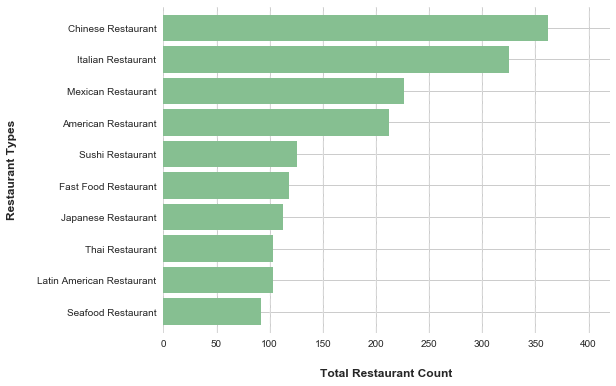

In [36]:
top_new_york_restaurant_types = new_york_grouped_melt.groupby('Restaurant Type')['Restaurant Count'].sum().sort_values().tail(10)

ax = top_new_york_restaurant_types.plot(kind='barh', figsize=(8, 6), color='#86bf91', zorder=2, width=0.85)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Total Restaurant Count", labelpad=20, weight='bold', size=12)

ax.set_ylabel("Restaurant Types", labelpad=20, weight='bold', size=12)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

Now, let's join the crime data and the location data.

In [37]:
new_york_combined = new_york_grouped.merge(new_york_crime_data_reshaped, on = 'Neighborhood', how = 'left')
new_york_combined = new_york_combined.fillna(0)

In [38]:
new_york_combined.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0       ALLERTON                  0                   0                    0   
1       ANNADALE                  0                   0                    3   
2  ARDEN HEIGHTS                  0                   0                    0   
3      ARLINGTON                  0                   0                    1   
4       ARROCHAR                  0                   0                    0   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0                 0                       0                 0   
1                 0                       0                 0   
2                 0                       0                 0   
3                 0                       0                 0   
4                 0                       0                 0   

   Australian Restaurant  Austrian Restaurant  Brazilian Restaurant  ...  \
0                      0                    0                     0  ...   
1                      0                    0                     0  ...   
2                      0                    0                     0  ...   
3                      0                    0                     0  ...   
4                      0                    0                     0  ...   

   Misdemeanor 2018  Misdemeanor 2019  Violation 2015  Violation 2016  \
0               0.0               0.0             0.0             0.0   
1               0.0               5.0             0.0             0.0   
2               0.0               4.0             0.0             0.0   
3               0.0               0.0             0.0             0.0   
4               0.0               2.0             0.0             0.0   

   Violation 2017  Violation 2018  Violation 2019  \
0             0.0             0.0             0.0   
1             0.0             0.0             1.0   
2             0.0             0.0             0.0   
3             0.0             0.0             0.0   
4             0.0             0.0             0.0   

   Average Number of Felony Cases  Average Number of Misdemeanor Cases  \
0                             0.0                                  0.0   
1                             0.2                                  1.0   
2                             0.2                                  0.8   
3                             0.0                                  0.0   
4                             0.2                                  0.4   

   Average Number of Violation Cases  
0                                0.0  
1                                0.2  
2                                0.0  
3                                0.0  
4                                0.0  

[5 rows x 107 columns]

Let's find the optimal number of clusters and then proceed with clustering.

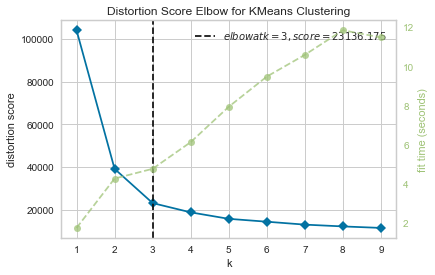

In [39]:
new_york_clustering = new_york_combined.drop('Neighborhood', 1)

model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k = (1,10))

visualizer.fit(new_york_clustering)
visualizer.show()

The optimal number of clusters is 3 using the elbow method. Let's proceed with clustering.

In [40]:
kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(new_york_clustering)

new_york_clustered = new_york_combined.copy()

new_york_clustered['Cluster'] = kmeans.labels_

In [41]:
new_york_data_coords = new_york_data.copy()
new_york_data_coords = new_york_data.drop('Borough', axis = 1)
new_york_data_coords['Neighborhood'] = new_york_data_coords['Neighborhood'].str.upper()

new_york_clustered_coords = new_york_clustered.merge(new_york_data_coords, on = 'Neighborhood', how = 'left')

In [42]:
new_york_clustered_coords.head(20)

Neighborhood  Afghan Restaurant  African Restaurant  \
0            ALLERTON                  0                   0   
1            ANNADALE                  0                   0   
2       ARDEN HEIGHTS                  0                   0   
3           ARLINGTON                  0                   0   
4            ARROCHAR                  0                   0   
5             ARVERNE                  0                   0   
6             ASTORIA                  0                   0   
7     ASTORIA HEIGHTS                  0                   0   
8          AUBURNDALE                  0                   0   
9          BATH BEACH                  0                   0   
10  BATTERY PARK CITY                  0                   0   
11          BAY RIDGE                  0                   0   
12        BAY TERRACE                  0                   0   
13        BAY TERRACE                  0                   0   
14        BAY TERRACE                  0                   0   
15        BAY TERRACE                  0                   0   
16         BAYCHESTER                  0                   0   
17            BAYSIDE                  0                   0   
18          BAYSWATER                  0                   0   
19       BEDFORD PARK                  0                   0   

    American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
0                     0                 0                       0   
1                     3                 0                       0   
2                     0                 0                       0   
3                     1                 0                       0   
4                     0                 0                       0   
5                     1                 0                       0   
6                     1                 0                       0   
7                     0                 0                       0   
8                     2                 0                       0   
9                     0                 0                       0   
10                    2                 0                       0   
11                    2                 0                       0   
12                    3                 0                       0   
13                    3                 0                       0   
14                    3                 0                       0   
15                    3                 0                       0   
16                    1                 0                       0   
17                    2                 0                       0   
18                    0                 0                       0   
19                    0                 0                       0   

    Asian Restaurant  Australian Restaurant  Austrian Restaurant  \
0                  0                      0                    0   
1                  0                      0                    0   
2                  0                      0                    0   
3                  0                      0                    0   
4                  0                      0                    0   
5                  0                      0                    0   
6                  0                      0                    0   
7                  0                      0                    0   
8                  0                      0                    0   
9                  0                      0                    0   
10                 0                      0                    0   
11                 0                      0                    0   
12                 0                      0                    0   
13                 0                      0                    0   
14                 0                      0                    0   
15                 0                      0                    0   
16                 0                      0               

Now, let's visualize the clusters.

In [43]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_york_clustered_coords['Latitude'], new_york_clustered_coords['Longitude'], new_york_clustered_coords['Neighborhood'], new_york_clustered_coords['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's see how many neighborhoods are in each cluster.

In [44]:
cluster_counts = new_york_clustered.groupby('Cluster')['Neighborhood'].count()

In [45]:
cluster_counts.head()

Cluster
0     74
1    212
2     18
Name: Neighborhood, dtype: int64

Most neighborhoods are under cluster 2 (1).

Now, let's examine each cluster to determine where we should build our new restaurant.

First, we will examine each cluster based on restaurant types.

In [46]:
new_york_top_restaurant_types = new_york_clustered.copy()
new_york_top_restaurant_types = new_york_top_restaurant_types.drop(['Felony 2015', 'Felony 2016', 'Felony 2017','Felony 2018', 'Felony 2019', 'Misdemeanor 2015', 'Misdemeanor 2016','Misdemeanor 2017', 'Misdemeanor 2018', 'Misdemeanor 2019','Violation 2015', 'Violation 2016', 'Violation 2017', 'Violation 2018','Violation 2019', 'Average Number of Felony Cases','Average Number of Misdemeanor Cases','Average Number of Violation Cases'], axis = 1)

In [47]:
new_york_top_restaurant_types = pd.melt(new_york_top_restaurant_types, id_vars=['Neighborhood', 'Cluster'], value_vars=['Afghan Restaurant', 'African Restaurant', 'American Restaurant','Arepa Restaurant', 'Argentinian Restaurant', 'Asian Restaurant','Australian Restaurant', 'Austrian Restaurant', 'Brazilian Restaurant','Burmese Restaurant', 'Cajun / Creole Restaurant','Cambodian Restaurant', 'Cantonese Restaurant', 'Caribbean Restaurant','Caucasian Restaurant', 'Chinese Restaurant', 'Colombian Restaurant','Comfort Food Restaurant', 'Cuban Restaurant', 'Czech Restaurant','Dim Sum Restaurant', 'Dumpling Restaurant','Eastern European Restaurant', 'Egyptian Restaurant','Empanada Restaurant', 'English Restaurant', 'Ethiopian Restaurant','Falafel Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant','French Restaurant', 'German Restaurant', 'Gluten-free Restaurant','Greek Restaurant', 'Halal Restaurant', 'Hawaiian Restaurant','Himalayan Restaurant', 'Hotpot Restaurant', 'Hunan Restaurant','Indian Restaurant', 'Indonesian Restaurant', 'Israeli Restaurant','Italian Restaurant', 'Japanese Curry Restaurant','Japanese Restaurant', 'Jewish Restaurant', 'Kebab Restaurant','Korean Restaurant', 'Kosher Restaurant', 'Latin American Restaurant','Lebanese Restaurant', 'Malay Restaurant', 'Mediterranean Restaurant','Mexican Restaurant', 'Middle Eastern Restaurant','Modern European Restaurant', 'Molecular Gastronomy Restaurant','Moroccan Restaurant', 'New American Restaurant','North Indian Restaurant', 'Paella Restaurant', 'Pakistani Restaurant','Persian Restaurant', 'Peruvian Restaurant', 'Polish Restaurant', 'Ramen Restaurant', 'Russian Restaurant', 'Scandinavian Restaurant', 'Seafood Restaurant','Shabu-Shabu Restaurant', 'Shanghai Restaurant', 'Soba Restaurant','South American Restaurant', 'Southern / Soul Food Restaurant','Spanish Restaurant', 'Sri Lankan Restaurant', 'Sushi Restaurant','Swiss Restaurant', 'Szechuan Restaurant', 'Taiwanese Restaurant','Tapas Restaurant', 'Tex-Mex Restaurant', 'Thai Restaurant', 'Tibetan Restaurant', 'Turkish Restaurant', 'Udon Restaurant', 'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant'], var_name = 'Restaurant Type', value_name = 'Restaurant Count')

In [48]:
new_york_top_restaurant_types.head()

Neighborhood  Cluster    Restaurant Type  Restaurant Count
0       ALLERTON        1  Afghan Restaurant                 0
1       ANNADALE        1  Afghan Restaurant                 0
2  ARDEN HEIGHTS        1  Afghan Restaurant                 0
3      ARLINGTON        1  Afghan Restaurant                 0
4       ARROCHAR        1  Afghan Restaurant                 0

Let's see the top restaurant types by cluster.

1. Cluster 1

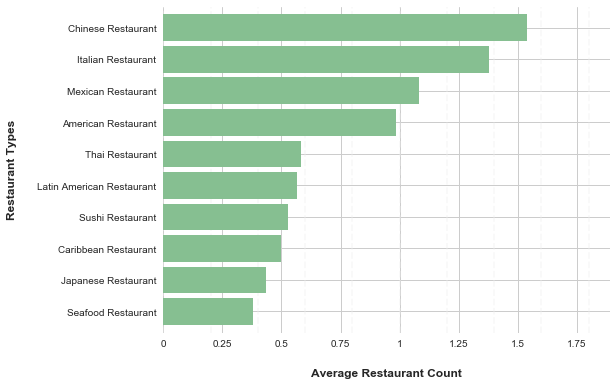

In [49]:
cluster1 = new_york_top_restaurant_types[new_york_top_restaurant_types.Cluster == 0]

top_cluster1_count = cluster1.groupby('Restaurant Type')['Restaurant Count'].mean().sort_values().tail(10)

ax = top_cluster1_count.plot(kind='barh', figsize=(8, 6), color='#86bf91', zorder=2, width=0.85)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Average Restaurant Count", labelpad=20, weight='bold', size=12)

ax.set_ylabel("Restaurant Types", labelpad=20, weight='bold', size=12)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

2. Cluster 2

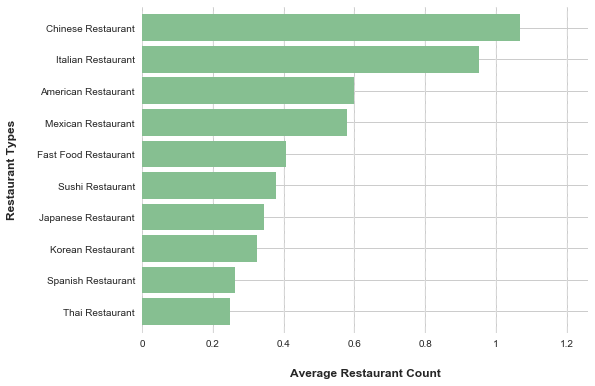

In [50]:
cluster2 = new_york_top_restaurant_types[new_york_top_restaurant_types.Cluster == 1]

top_cluster2_count = cluster2.groupby('Restaurant Type')['Restaurant Count'].mean().sort_values().tail(10)

ax = top_cluster2_count.plot(kind='barh', figsize=(8, 6), color='#86bf91', zorder=2, width=0.85)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Average Restaurant Count", labelpad=20, weight='bold', size=12)

ax.set_ylabel("Restaurant Types", labelpad=20, weight='bold', size=12)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

3. Cluster 3

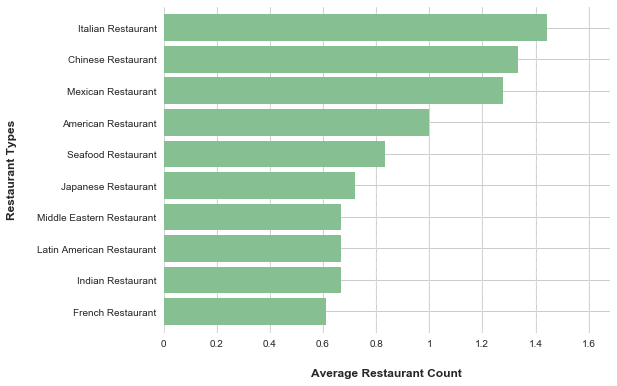

In [51]:
cluster3 = new_york_top_restaurant_types[new_york_top_restaurant_types.Cluster == 2]

top_cluster3_count = cluster3.groupby('Restaurant Type')['Restaurant Count'].mean().sort_values().tail(10)

ax = top_cluster3_count.plot(kind='barh', figsize=(8, 6), color='#86bf91', zorder=2, width=0.85)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Average Restaurant Count", labelpad=20, weight='bold', size=12)

ax.set_ylabel("Restaurant Types", labelpad=20, weight='bold', size=12)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

According to the graphs, Chinese, Italian, Mexican, and American Restaurants are the most common restaurants in all clusters. Cluster 2 also has fewer restaurants and Cluster 1 has more restaurants on average.

Now, let's examine each cluster based on crime rates.

In [52]:
new_york_top_crime = new_york_clustered.copy()
new_york_top_crime = new_york_top_crime.drop(['Afghan Restaurant', 'African Restaurant', 'American Restaurant', 'Arepa Restaurant', 'Argentinian Restaurant', 'Asian Restaurant','Australian Restaurant', 'Austrian Restaurant', 'Brazilian Restaurant','Burmese Restaurant', 'Cajun / Creole Restaurant','Cambodian Restaurant', 'Cantonese Restaurant', 'Caribbean Restaurant','Caucasian Restaurant', 'Chinese Restaurant', 'Colombian Restaurant','Comfort Food Restaurant', 'Cuban Restaurant', 'Czech Restaurant','Dim Sum Restaurant', 'Dumpling Restaurant','Eastern European Restaurant', 'Egyptian Restaurant','Empanada Restaurant', 'English Restaurant', 'Ethiopian Restaurant','Falafel Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant','French Restaurant', 'German Restaurant', 'Gluten-free Restaurant','Greek Restaurant', 'Halal Restaurant', 'Hawaiian Restaurant','Himalayan Restaurant', 'Hotpot Restaurant', 'Hunan Restaurant','Indian Restaurant', 'Indonesian Restaurant', 'Israeli Restaurant','Italian Restaurant', 'Japanese Curry Restaurant','Japanese Restaurant', 'Jewish Restaurant', 'Kebab Restaurant','Korean Restaurant', 'Kosher Restaurant', 'Latin American Restaurant','Lebanese Restaurant', 'Malay Restaurant', 'Mediterranean Restaurant','Mexican Restaurant', 'Middle Eastern Restaurant','Modern European Restaurant', 'Molecular Gastronomy Restaurant','Moroccan Restaurant', 'New American Restaurant','North Indian Restaurant', 'Paella Restaurant', 'Pakistani Restaurant','Persian Restaurant', 'Peruvian Restaurant', 'Polish Restaurant','Ramen Restaurant', 'Russian Restaurant','Scandinavian Restaurant', 'Seafood Restaurant','Shabu-Shabu Restaurant', 'Shanghai Restaurant', 'Soba Restaurant','South American Restaurant', 'Southern / Soul Food Restaurant','Spanish Restaurant', 'Sri Lankan Restaurant', 'Sushi Restaurant','Swiss Restaurant', 'Szechuan Restaurant', 'Taiwanese Restaurant','Tapas Restaurant', 'Tex-Mex Restaurant', 'Thai Restaurant','Tibetan Restaurant', 'Turkish Restaurant', 'Udon Restaurant','Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant', 'Felony 2015', 'Felony 2016', 'Felony 2017','Felony 2018', 'Felony 2019', 'Misdemeanor 2015', 'Misdemeanor 2016','Misdemeanor 2017', 'Misdemeanor 2018', 'Misdemeanor 2019','Violation 2015', 'Violation 2016', 'Violation 2017', 'Violation 2018','Violation 2019'], axis = 1)
new_york_top_crime = new_york_top_crime.rename(columns = {'Average Number of Felony Cases': 'Felony', 'Average Number of Misdemeanor Cases': 'Misdemeanor', 'Average Number of Violation Cases': 'Violation'})

In [53]:
new_york_top_crime = pd.melt(new_york_top_crime, id_vars=['Neighborhood', 'Cluster'], value_vars=['Felony', 'Misdemeanor', 'Violation'], var_name = 'Level of Offense', value_name = 'Average Case Count')

In [54]:
new_york_top_crime.head()

Neighborhood  Cluster Level of Offense  Average Case Count
0       ALLERTON        1           Felony                 0.0
1       ANNADALE        1           Felony                 0.2
2  ARDEN HEIGHTS        1           Felony                 0.2
3      ARLINGTON        1           Felony                 0.0
4       ARROCHAR        1           Felony                 0.2

1. Cluster 1

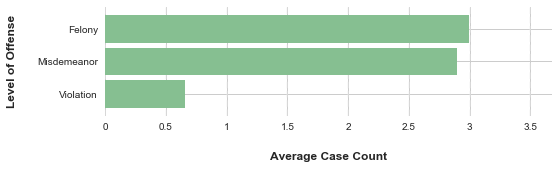

In [55]:
cluster1 = new_york_top_crime[new_york_top_crime.Cluster == 0]

top_cluster1_count = cluster1.groupby('Level of Offense')['Average Case Count'].mean().sort_values().tail(10)

ax = top_cluster1_count.plot(kind='barh', figsize=(8, 2), color='#86bf91', zorder=2, width=0.85)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Average Case Count", labelpad=20, weight='bold', size=12)

ax.set_ylabel("Level of Offense", labelpad=20, weight='bold', size=12)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

2. Cluster 2

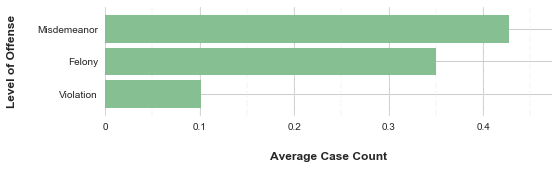

In [56]:
cluster2 = new_york_top_crime[new_york_top_crime.Cluster == 1]

top_cluster2_count = cluster2.groupby('Level of Offense')['Average Case Count'].mean().sort_values().tail(10)

ax = top_cluster2_count.plot(kind='barh', figsize=(8, 2), color='#86bf91', zorder=2, width=0.85)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Average Case Count", labelpad=20, weight='bold', size=12)

ax.set_ylabel("Level of Offense", labelpad=20, weight='bold', size=12)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

3. Cluster 3

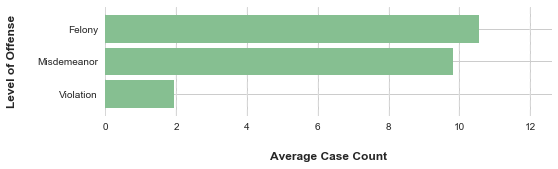

In [57]:
cluster3 = new_york_top_crime[new_york_top_crime.Cluster == 2]

top_cluster3_count = cluster3.groupby('Level of Offense')['Average Case Count'].mean().sort_values().tail(10)

ax = top_cluster3_count.plot(kind='barh', figsize=(8, 2), color='#86bf91', zorder=2, width=0.85)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_xlabel("Average Case Count", labelpad=20, weight='bold', size=12)

ax.set_ylabel("Level of Offense", labelpad=20, weight='bold', size=12)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

According to the graphs, Cluster 2 has the lowest average crime count while Cluster 3 gas the highest average crime count. This suggests that neighborhoods in Cluster 3 are not that safe while neighborhoods in Cluster 2 are pretty safe. Cluster 1 also has pretty low average crime count.

Going back to the questions that we want to answer:

1. **Which neighborhood(s) is/are the best location(s) to build a new restaurant considering the following factors:**
    - Historical crime rate
    - Number of competitors
    
**Cluster 2** neighborhoods have the things that we are looking for because the average restaurant count is the lowest among three clusters, which suggests that competition is not that intense. Crimes are also almost nonexistent in these areas, which is good for the business in the long run.

2. **What cuisine dominates in each of the neighborhoods?**

Chinese, Italian, Mexican, and American Restaurants are the most common restaurants in the cluster, so creating a new restaurant that is similar to these restaurants may not appeal to customers.

3. **Knowing these things, what cuisine could be introduced to the location?**

There are a lot of cuisine that can still be introduced to the neighborhoods; however, to reduce risks, it would be good to introduce something that is not completely new to the neighborhoods like European cuisine (French, Greek) or other Asian cuisine (Japanese, Korean, Thai, Indian, and Filipino). In this case, going with other Asian cuisine may be a better option because the data shows that Asian restaurants are more common and familiar in the area, so it would be easier for the company to attract new customers.